In [18]:
import os
import json
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from scipy.ndimage import rotate
from tqdm import tqdm
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
def plot_sample_slices(image, label, prediction=None, slice_idx=None):
    """Plot sample slices from the 3D volume for visual inspection."""
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3 if prediction is not None else 2, figsize=(15, 5))
    
    # Plot original image (first modality)
    axes[0].imshow(image[:, :, slice_idx, 0], cmap='gray')
    axes[0].set_title('Original Image (First Modality)')
    
    # Plot ground truth
    axes[1].imshow(np.argmax(label[:, :, slice_idx], axis=-1), cmap='nipy_spectral')
    axes[1].set_title('Ground Truth')
    
    if prediction is not None:
        axes[2].imshow(np.argmax(prediction[:, :, slice_idx], axis=-1), cmap='nipy_spectral')
        axes[2].set_title('Prediction')
    
    plt.tight_layout()
    plt.show()

def analyze_class_distribution(labels):
    """Analyze class distribution in the dataset."""
    class_counts = []
    for label in labels:
        unique, counts = np.unique(label, return_counts=True)
        class_counts.append(dict(zip(unique, counts)))
    
    # Calculate average distribution
    total_dist = {}
    for d in class_counts:
        for k, v in d.items():
            total_dist[k] = total_dist.get(k, 0) + v
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.bar(total_dist.keys(), [v/len(class_counts) for v in total_dist.values()])
    plt.title('Average Class Distribution per Volume')
    plt.xlabel('Class')
    plt.ylabel('Average Number of Voxels')
    plt.yscale('log')
    plt.show()
    
    return total_dist

In [20]:
class BrainTumor3DDataset:
    def __init__(self, base_path):
        self.base_path = base_path
        self.dataset_json = self._load_dataset_json()
        self.train_files = self._get_training_files()
        
    def _load_dataset_json(self):
        json_path = os.path.join(self.base_path, 'ML_Decathlon_Dataset/Task01_BrainTumour/dataset.json')
        with open(json_path, 'r') as f:
            return json.load(f)
    
    def _get_training_files(self):
        return self.dataset_json['training']
    
    def validate_data_integrity(self, images, labels):
        """Validate data integrity and check for potential issues."""
        print("\nData Validation Report:")
        print("-----------------------")
        
        # Check shapes
        print(f"Number of samples: {len(images)}")
        print(f"Image shape: {images[0].shape}")
        print(f"Label shape: {labels[0].shape}")
        
        # Check value ranges
        for i, (img, lbl) in enumerate(zip(images, labels)):
            print(f"\nSample {i}:")
            print(f"Image value range: [{np.min(img):.3f}, {np.max(img):.3f}]")
            print(f"Unique labels: {np.unique(lbl)}")
            
            # Check for NaN/Inf
            if np.any(np.isnan(img)) or np.any(np.isinf(img)):
                print("WARNING: Found NaN or Inf values in image!")
            
            # Check label validity
            if not np.array_equal(np.unique(lbl), np.arange(len(np.unique(lbl)))):
                print("WARNING: Labels might not be consecutive integers!")
        
        return True

    def load_volume(self, file_path):
        full_path = os.path.join(self.base_path, 'ML_Decathlon_Dataset/Task01_BrainTumour', 
                                file_path.replace('./', ''))
        return nib.load(full_path).get_fdata()

    def analyze_class_distribution(self, labels):
        """Analyze class distribution in the dataset"""
        class_counts = {}
        total_voxels = 0
        
        for label_volume in labels:
            unique, counts = np.unique(label_volume, return_counts=True)
            total_voxels += label_volume.size
            
            for class_idx, count in zip(unique, counts):
                if class_idx not in class_counts:
                    class_counts[class_idx] = 0
                class_counts[class_idx] += count
        
        # Convert to percentages
        class_percentages = {k: (v/total_voxels)*100 for k, v in class_counts.items()}
        
        return class_counts, class_percentages

    def preprocess_volume(self, volume):
        """Optimized preprocessing using vectorized operations"""
        preprocessed = np.zeros_like(volume, dtype=np.float32)
        for i in range(volume.shape[-1]):
            modality = volume[..., i]
            nonzero_mask = modality != 0
            if np.any(nonzero_mask):
                mean = np.mean(modality[nonzero_mask])
                std = np.std(modality[nonzero_mask])
                if std != 0:
                    preprocessed[..., i] = (modality - mean) / std
        return preprocessed

    def prepare_data(self, num_samples=None):
        images = []
        labels = []
        
        train_files = self.train_files[:num_samples] if num_samples else self.train_files
        
        for idx, file_info in tqdm(enumerate(train_files), desc="Loading data", total=len(train_files)):
            try:
                image = self.load_volume(file_info['image'])
                label = self.load_volume(file_info['label'])
                
                # Check for potential data issues
                if np.any(np.isnan(image)) or np.any(np.isinf(image)):
                    print(f"Warning: Found NaN or Inf values in image {idx}")
                    continue
                
                image = self.preprocess_volume(image)
                
                images.append(image)
                labels.append(label)
                
                gc.collect()
                
            except Exception as e:
                print(f"Error processing file {idx}: {e}")
                continue
            
        return images, labels

In [21]:
class DataGenerator3D(Sequence):
    def __init__(self, image_list, label_list, batch_size=1, patch_size=(64, 64, 64),
                 n_channels=4, n_classes=4, shuffle=True, augment=False):
        self.image_list = image_list
        self.label_list = label_list
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        # Initialize valid_patches before calling on_epoch_end
        self.valid_patches = []
        self._calculate_valid_patches()
        self.on_epoch_end()
        
        # Validate patch extraction
        self._validate_patch_extraction()
    
    def _validate_patch_extraction(self):
        """Validate the first few patches to ensure correct extraction."""
        print("\nPatch Validation:")
        print("----------------")
        
        for i in range(min(3, len(self.valid_patches))):
            img_idx, x, y, z = self.valid_patches[i]
            patch_x, patch_y = self._extract_patch(img_idx, x, y, z)
            
            print(f"\nPatch {i}:")
            print(f"Shape: {patch_x.shape}")
            print(f"Value range: [{np.min(patch_x):.3f}, {np.max(patch_x):.3f}]")
            print(f"Unique labels: {np.unique(np.argmax(patch_y, axis=-1))}")

    def analyze_patch_distribution(self):
        """Analyze class distribution in selected patches"""
        class_counts = np.zeros(self.n_classes)
        for idx, (img_idx, x, y, z) in enumerate(self.valid_patches[:100]):  # Sample first 100 patches
            label_patch = self.label_list[img_idx][
                x:x + self.patch_size[0],
                y:y + self.patch_size[1],
                z:z + self.patch_size[2]
            ]
            unique, counts = np.unique(label_patch, return_counts=True)
            for class_idx, count in zip(unique, counts):
                class_counts[int(class_idx)] += count
                
        total_voxels = np.sum(class_counts)
        class_percentages = (class_counts / total_voxels) * 100
        
        print("\nPatch-wise class distribution:")
        for i, percentage in enumerate(class_percentages):
            print(f"Class {i}: {percentage:.2f}%")

    def _calculate_valid_patches(self):
        valid_patches = []
        stride = [p // 2 for p in self.patch_size]
        
        for idx, image in enumerate(self.image_list):
            x_coords = range(0, image.shape[0] - self.patch_size[0], stride[0])
            y_coords = range(0, image.shape[1] - self.patch_size[1], stride[1])
            z_coords = range(0, image.shape[2] - self.patch_size[2], stride[2])
            
            for x in x_coords:
                for y in y_coords:
                    for z in z_coords:
                        patch = image[x:x + self.patch_size[0],
                                    y:y + self.patch_size[1],
                                    z:z + self.patch_size[2]]
                        if np.any(patch):
                            valid_patches.append((idx, x, y, z))
        
        self.valid_patches = valid_patches
        print(f"Total valid patches: {len(self.valid_patches)}")

    def __len__(self):
        return int(np.ceil(len(self.valid_patches) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.valid_patches))
        batch_patches = self.valid_patches[start_idx:end_idx]
        
        batch_size = len(batch_patches)
        X = np.zeros((batch_size, *self.patch_size, self.n_channels), dtype=np.float32)
        y = np.zeros((batch_size, *self.patch_size, self.n_classes), dtype=np.float32)

        for i, (img_idx, x, y_coord, z) in enumerate(batch_patches):
            X[i], y[i] = self._extract_patch(img_idx, x, y_coord, z)

        return X, y

    def _extract_patch(self, img_idx, x, y, z):
        image = self.image_list[img_idx]
        label = self.label_list[img_idx]

        patch_x = image[x:x + self.patch_size[0],
                       y:y + self.patch_size[1],
                       z:z + self.patch_size[2]].astype(np.float32)

        patch_y = np.zeros((*self.patch_size, self.n_classes), dtype=np.float32)
        for c in range(self.n_classes):
            patch_y[..., c] = (label[x:x + self.patch_size[0],
                                    y:y + self.patch_size[1],
                                    z:z + self.patch_size[2]] == c)

        if self.augment:
            patch_x, patch_y = self._augment_data(patch_x, patch_y)

        return patch_x, patch_y

    @staticmethod
    def _augment_data(image, label):
        if np.random.random() > 0.5:
            angle = np.random.uniform(-20, 20)
            image = np.stack([rotate(image[..., c], angle, axes=(0, 1), reshape=False)
                            for c in range(image.shape[-1])], axis=-1)
            label = np.stack([rotate(label[..., c], angle, axes=(0, 1), reshape=False)
                            for c in range(label.shape[-1])], axis=-1)
        return image, label

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.valid_patches)

In [22]:
# import signal
# import sys

# class ModelSaver:
#     def __init__(self):
#         self.model = None
#         self.stop_training = False
#         self.history = None
        
#     def save_model(self, signum, frame):
#         print('\nCtrl+C detected. Saving model and training history...')
#         self.stop_training = True
#         if self.model is not None:
#             # Save model
#             self.model.save('interrupted_model.keras')
#             print('Model saved as interrupted_model.keras')
            
#             # Save training history if it exists
#             if self.history is not None:
#                 import pickle
#                 with open('training_history.pkl', 'wb') as f:
#                     pickle.dump(self.history.history, f)
#                 print('Training history saved as training_history.pkl')
#         sys.exit(0)

# def train_model(validation_split=0.2, max_epochs=30, num_samples=10):
#     """
#     Train the 3D U-Net model with the ability to save on interrupt
#     """
#     # Initialize model saver and set up interrupt handler
#     model_saver = ModelSaver()
#     signal.signal(signal.SIGINT, model_saver.save_model)
    
#     try:
#         # Initialize dataset
#         dataset = BrainTumor3DDataset(base_path='.')
        
#         print("Starting data preparation...")
#         images, labels = dataset.prepare_data(num_samples=num_samples)
        
#         # Analyze class distribution
#         print("\nAnalyzing class distribution...")
#         class_dist = analyze_class_distribution(labels)
        
#         # Validate data integrity
#         dataset.validate_data_integrity(images, labels)
        
#         print("\nCreating train/val split...")
#         X_train, X_val, y_train, y_val = train_test_split(
#             images, labels, test_size=validation_split, random_state=42
#         )
        
#         # Clear memory
#         del images, labels
#         gc.collect()
        
#         # Calculate class weights based on distribution
#         total_pixels = sum(class_dist.values())
#         class_weights = {
#             i: total_pixels / (len(class_dist) * count)
#             for i, count in class_dist.items()
#         }
        
#         # Create data generators
#         patch_size = (64, 64, 64)
#         train_generator = DataGenerator3D(
#             X_train, y_train, batch_size=1, patch_size=patch_size, augment=True
#         )
#         val_generator = DataGenerator3D(
#             X_val, y_val, batch_size=1, patch_size=patch_size, augment=False
#         )
        
#         # Create and compile model
#         input_shape = (*patch_size, 4)
#         model = create_3d_unet(input_shape, n_classes=4)
        
#         optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
        
#         model.compile(
#             optimizer=optimizer,
#             loss=dice_loss,
#             metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
#         )
        
#         # Store model in model_saver
#         model_saver.model = model
        
#         # Create a custom callback for periodic saving
#         class PeriodicModelSaver(tf.keras.callbacks.Callback):
#             def __init__(self, save_freq=100):  # save_freq in steps
#                 super().__init__()
#                 self.save_freq = save_freq
#                 self.steps = 0
                
#             def on_batch_end(self, batch, logs=None):
#                 self.steps += 1
#                 if self.steps % self.save_freq == 0:
#                     self.model.save(f'model_checkpoint_step_{self.steps}.keras')
#                     print(f'\nSaved model at step {self.steps}')
        
#         # Enhanced callbacks
#         callbacks = [
#             tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=5,
#                 min_delta=0.001,
#                 restore_best_weights=True,
#                 verbose=1
#             ),
#             tf.keras.callbacks.ModelCheckpoint(
#                 'best_3d_model.keras',
#                 save_best_only=True,
#                 monitor='val_loss',
#                 mode='min',
#                 verbose=1
#             ),
#             tf.keras.callbacks.ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=0.5,
#                 patience=3,
#                 min_lr=1e-6,
#                 mode='min',
#                 verbose=1
#             ),
#             tf.keras.callbacks.CSVLogger('training_log.csv'),
#             PeriodicModelSaver(save_freq=100),  # Save every 100 steps
#             tf.keras.callbacks.LambdaCallback(
#                 on_epoch_end=lambda epoch, logs: gc.collect()
#             )
#         ]
        
#         # Train model
#         history = model.fit(
#             train_generator,
#             validation_data=val_generator,
#             epochs=max_epochs,
#             callbacks=callbacks,
#             class_weight=class_weights
#         )
        
#         # Store history in model_saver
#         model_saver.history = history
        
#         return model, history
    
#     except KeyboardInterrupt:
#         print('\nTraining interrupted by user. Saving model...')
#         if model_saver.model is not None:
#             model_saver.model.save('interrupted_model.keras')
#             print('Model saved as interrupted_model.keras')
            
#             # Save partial history if it exists
#             if hasattr(model_saver.model, 'history') and model_saver.model.history is not None:
#                 import pickle
#                 with open('partial_training_history.pkl', 'wb') as f:
#                     pickle.dump(model_saver.model.history.history, f)
#                 print('Partial training history saved as partial_training_history.pkl')
        
#         return model_saver.model, model_saver.model.history if hasattr(model_saver.model, 'history') else None
    
#     except Exception as e:
#         print(f'\nAn error occurred during training: {str(e)}')
#         if model_saver.model is not None:
#             model_saver.model.save('error_model.keras')
#             print('Model saved as error_model.keras')
#         raise e

# # To load a saved model later:
# def load_saved_model(model_path='interrupted_model.keras', history_path='training_history.pkl'):
#     """
#     Load a saved model and its training history
#     """
#     try:
#         # Load model
#         model = tf.keras.models.load_model(model_path, custom_objects={'dice_loss': dice_loss})
#         print(f'Model loaded from {model_path}')
        
#         # Try to load history
#         try:
#             import pickle
#             with open(history_path, 'rb') as f:
#                 history = pickle.load(f)
#             print(f'Training history loaded from {history_path}')
#             return model, history
#         except:
#             print('No training history found')
#             return model, None
            
#     except Exception as e:
#         print(f'Error loading model: {str(e)}')
#         return None, None

In [23]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import gc

def create_3d_unet(input_shape, n_classes=4, n_filters=16):
    """Create 3D U-Net model architecture"""
    inputs = tf.keras.Input(input_shape)
    
    # Encoder
    conv1 = conv_block_3d(inputs, n_filters)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    
    conv2 = conv_block_3d(pool1, n_filters*2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    
    conv3 = conv_block_3d(pool2, n_filters*4)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    # Bridge
    conv4 = conv_block_3d(pool3, n_filters*8)
    
    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(n_filters*4, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3])
    conv5 = conv_block_3d(concat5, n_filters*4)
    
    up6 = tf.keras.layers.Conv3DTranspose(n_filters*2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2])
    conv6 = conv_block_3d(concat6, n_filters*2)
    
    up7 = tf.keras.layers.Conv3DTranspose(n_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1])
    conv7 = conv_block_3d(concat7, n_filters)
    
    # Output
    outputs = tf.keras.layers.Conv3D(n_classes, (1, 1, 1), activation='softmax')(conv7)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def conv_block_3d(inputs, n_filters, kernel_size=(3, 3, 3)):
    """Create a 3D convolution block"""
    x = tf.keras.layers.Conv3D(n_filters, kernel_size, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv3D(n_filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def dice_loss(y_true, y_pred):
    """Calculate Dice loss"""
    smooth = 1e-5
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    
    return 1 - numerator / denominator

class TrainingController:
    def __init__(self):
        self.stop_training = False
        self.button = widgets.Button(description='Stop Training')
        self.button.on_click(self.on_button_clicked)
        display(self.button)
    
    def on_button_clicked(self, b):
        self.stop_training = True
        print("\nStopping training after current epoch completes...")

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, controller):
        super().__init__()
        self.controller = controller
        
    def on_epoch_end(self, epoch, logs=None):
        if self.controller.stop_training:
            self.model.stop_training = True
            print("\nSaving model...")
            self.model.save(f'model_stopped_epoch_{epoch}.keras')

def train_model(validation_split=0.2, max_epochs=30, num_samples=10):
    """Train the 3D U-Net model with stop button functionality"""
    try:
        # Initialize controller for stop button
        controller = TrainingController()
        
        # Initialize dataset
        dataset = BrainTumor3DDataset(base_path='.')
        
        print("Starting data preparation...")
        images, labels = dataset.prepare_data(num_samples=num_samples)
        
        # Analyze class distribution
        print("\nAnalyzing class distribution...")
        class_dist = analyze_class_distribution(labels)
        
        # Validate data integrity
        dataset.validate_data_integrity(images, labels)
        
        print("\nCreating train/val split...")
        X_train, X_val, y_train, y_val = train_test_split(
            images, labels, test_size=validation_split, random_state=42
        )
        
        # Clear memory
        del images, labels
        gc.collect()
        
        # Calculate class weights
        total_pixels = sum(class_dist.values())
        class_weights = {
            i: total_pixels / (len(class_dist) * count)
            for i, count in class_dist.items()
        }
        
        # Create data generators
        patch_size = (64, 64, 64)
        train_generator = DataGenerator3D(
            X_train, y_train, batch_size=1, patch_size=patch_size, augment=True, class_weights=class_weights
        )
        val_generator = DataGenerator3D(
            X_val, y_val, batch_size=1, patch_size=patch_size, augment=False
        )
        
        # Create and compile model
        input_shape = (*patch_size, 4)
        model = create_3d_unet(input_shape, n_classes=4)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
        
        model.compile(
            optimizer=optimizer,
            loss=dice_loss,
            metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)]
        )
        
        # Enhanced callbacks with stop button
        callbacks = [
            CustomCallback(controller),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                min_delta=0.001,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_3d_model.keras',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6,
                mode='min',
                verbose=1
            ),
            tf.keras.callbacks.CSVLogger('training_log.csv'),
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: gc.collect()
            )
        ]
        
        # Train model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=max_epochs,
            callbacks=callbacks
        )
        
        return model, history
    
    except Exception as e:
        print(f'\nAn error occurred during training: {str(e)}')
        if 'model' in locals():
            model.save('error_model.keras')
            print('Model saved as error_model.keras')
        raise e


In [24]:
def evaluate_model(model, val_generator):
    """Evaluate model performance with detailed metrics."""
    print("\nModel Evaluation:")
    print("----------------")
    
    # Get predictions for validation set
    val_predictions = []
    val_true = []
    
    for i in range(len(val_generator)):
        x, y = val_generator[i]
        pred = model.predict(x)
        val_predictions.append(pred)
        val_true.append(y)
    
    val_pred = np.concatenate(val_predictions)
    val_true = np.concatenate(val_true)
    
    # Calculate metrics
    accuracy = np.mean(np.argmax(val_pred, axis=-1) == np.argmax(val_true, axis=-1))
    
    # Create confusion matrix
    cm = confusion_matrix(
        np.argmax(val_true.reshape(-1, val_true.shape[-1]), axis=-1),
        np.argmax(val_pred.reshape(-1, val_pred.shape[-1]), axis=-1)
    )
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    
    # Calculate per-class metrics
    for i in range(val_true.shape[-1]):
        class_acc = np.mean(
            np.argmax(val_pred, axis=-1)[np.argmax(val_true, axis=-1) == i] == i
        )
        print(f"Class {i} Accuracy: {class_acc:.4f}")
    
    return accuracy, cm

Button(description='Stop Training', style=ButtonStyle())

Starting data preparation...


Loading data: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]



Analyzing class distribution...


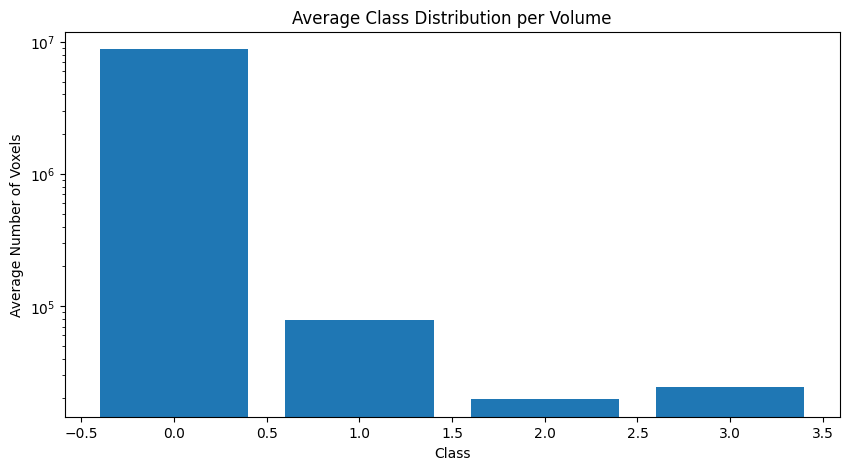


Data Validation Report:
-----------------------
Number of samples: 10
Image shape: (240, 240, 155, 4)
Label shape: (240, 240, 155)

Sample 0:
Image value range: [-5.103, 10.282]
Unique labels: [0. 1. 2. 3.]

Sample 1:
Image value range: [-3.452, 12.930]
Unique labels: [0. 1. 2. 3.]

Sample 2:
Image value range: [-4.458, 11.208]
Unique labels: [0. 1. 2. 3.]

Sample 3:
Image value range: [-4.506, 12.677]
Unique labels: [0. 1. 2. 3.]

Sample 4:
Image value range: [-3.708, 12.848]
Unique labels: [0. 1. 2. 3.]

Sample 5:
Image value range: [-5.864, 10.379]
Unique labels: [0. 1. 2. 3.]

Sample 6:
Image value range: [-4.986, 13.716]
Unique labels: [0. 1. 2. 3.]

Sample 7:
Image value range: [-3.634, 12.997]
Unique labels: [0. 1. 2. 3.]

Sample 8:
Image value range: [-5.502, 11.336]
Unique labels: [0. 1. 2. 3.]

Sample 9:
Image value range: [-4.710, 11.241]
Unique labels: [0. 1. 2. 3.]

Creating train/val split...

An error occurred during training: DataGenerator3D.__init__() got an unexpecte

TypeError: DataGenerator3D.__init__() got an unexpected keyword argument 'class_weights'

In [25]:
if __name__ == "__main__":
    # Set memory growth for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    
    # Train model
    model, history = train_model(num_samples=10)
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_io_u'], label='Training IoU')
    plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history_3d.png')
    plt.show()